#  Logistic Regression

In [3]:
import pandas as pd
import numpy as np
from collections import Counter

In [4]:
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import grid_search

from scipy.sparse import lil_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split

In [5]:
train_df = pd.read_json("train.json")
test_df = pd.read_json("test.json") 

In [6]:
cuisines = list(train_df.cuisine.unique())

ingredient_dict = {}
for cuisine in cuisines:
    ingredient_dict[cuisine] = Counter(",".join(
            [",".join(_) for _ in train_df[train_df.cuisine == cuisine]['ingredients'].values]).split(","))

In [7]:
c = Counter(";".join([";".join(_) for _ in train_df.ingredients.values]).split(";"))

In [8]:
list(c.keys()).index("butter")
ingredients_index = list(c.keys())

In [9]:
%%time
n = train_df.shape[0]
m = len(c.keys())
X = lil_matrix((n, m), dtype=np.int)
y = np.zeros(n, dtype=np.int)
for recipe in range(n):
    y[recipe] = cuisines.index(train_df.loc[recipe].cuisine)
    for ingr in train_df.loc[recipe].ingredients:
        X[recipe, ingredients_index.index(ingr)] = 1

CPU times: user 1min 25s, sys: 923 ms, total: 1min 26s
Wall time: 1min 25s


In [10]:
y[:500]

array([ 0,  1,  2,  3,  3,  4,  5,  6,  7,  6,  6,  8,  6,  7,  6,  3,  9,
        6, 10, 11, 10,  7,  1,  8,  6,  8, 12,  6,  8,  7,  6, 12,  7, 10,
        6, 12,  6,  2,  1,  1,  6, 13,  7,  3,  7,  8, 14,  1,  1,  1, 15,
        1,  6,  1,  6,  4, 15,  3,  6, 16, 10, 10,  3,  4,  6, 10, 17, 14,
       14,  1,  5,  3, 18,  6,  6, 18, 18, 11, 15,  7, 12,  1, 14,  3,  3,
        6,  6,  3, 17,  5,  6,  1,  1,  0,  7,  7,  1,  3,  6,  6,  6, 15,
        6,  0, 17,  3,  7,  1, 16, 17,  8,  7,  1,  8, 18, 16,  8, 16,  7,
        6,  6,  6,  4,  7, 15,  5,  8,  7,  9,  3, 10,  1,  7,  5, 14,  6,
        3,  9,  5,  6, 17,  3,  7,  7,  1, 14, 12,  3,  8,  6,  6,  6,  1,
        0, 15, 12,  6, 17,  7,  3,  6,  7, 17,  8, 14,  8,  5,  8,  5, 15,
        7, 14, 15,  7,  6,  2,  1,  6,  6,  8,  7,  3, 17,  7,  7, 15,  0,
        7,  1,  8,  9, 15,  6,  7, 16,  0, 12, 15,  6,  1,  1,  1,  6,  3,
        8, 15,  7,  7, 14,  7,  7, 16,  8,  7,  0, 17,  7,  5,  6,  1,  6,
        7, 14,  7, 14,  2

In [11]:
X

<39774x6714 sparse matrix of type '<type 'numpy.int64'>'
	with 428249 stored elements in LInked List format>

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [13]:
%%time
ind = np.array((X.sum(axis=0) < 1000) & (X.sum(axis=0) > 5)).ravel()
logistic = LogisticRegression()
logistic.fit(X_train[:, ind], y_train)
print('LogisticRegression score: %f' % logistic.score(X_test[:, ind], y_test))

LogisticRegression score: 0.743055
CPU times: user 2.82 s, sys: 74.7 ms, total: 2.9 s
Wall time: 2.91 s


In [14]:
res = []
logmax = np.log10(18049) # (u'salt', 18049)
for lower_bound in np.logspace(0, 3, num=10):
    for upper_bound in np.logspace(np.log(lower_bound), logmax, num=10):
        ind = np.array((X.sum(axis=0) <= upper_bound) & (X.sum(axis=0) >= lower_bound)).ravel()
        logistic = LogisticRegression()
        logistic.fit(X_train[:, ind], y_train)
        score = logistic.score(X_test[:, ind], y_test)
        print('LogisticRegression score: %f' % score)
        res.append((lower_bound, upper_bound, score))

LogisticRegression score: 0.196983
LogisticRegression score: 0.201006
LogisticRegression score: 0.242615
LogisticRegression score: 0.332621
LogisticRegression score: 0.471276
LogisticRegression score: 0.621370
LogisticRegression score: 0.724576
LogisticRegression score: 0.773727
LogisticRegression score: 0.781898
LogisticRegression score: 0.783532
LogisticRegression score: 0.217222
LogisticRegression score: 0.278567
LogisticRegression score: 0.362162
LogisticRegression score: 0.480327
LogisticRegression score: 0.608297
LogisticRegression score: 0.714771
LogisticRegression score: 0.754117
LogisticRegression score: 0.778001
LogisticRegression score: 0.781647
LogisticRegression score: 0.783281
LogisticRegression score: 0.354368
LogisticRegression score: 0.450911
LogisticRegression score: 0.544689
LogisticRegression score: 0.643872
LogisticRegression score: 0.715399
LogisticRegression score: 0.747832
LogisticRegression score: 0.771464
LogisticRegression score: 0.781144
LogisticRegression s

In [15]:
%%time
logistic = LogisticRegression()
logistic.fit(X_train, y_train)
print('LogisticRegression score: %f' % logistic.score(X_test, y_test))

LogisticRegression score: 0.783532
CPU times: user 6.95 s, sys: 30.6 ms, total: 6.98 s
Wall time: 7 s


In [17]:
import warnings;
with warnings.catch_warnings():
    warnings.simplefilter("ignore"); 
    import matplotlib.pyplot as plt    
%matplotlib inline

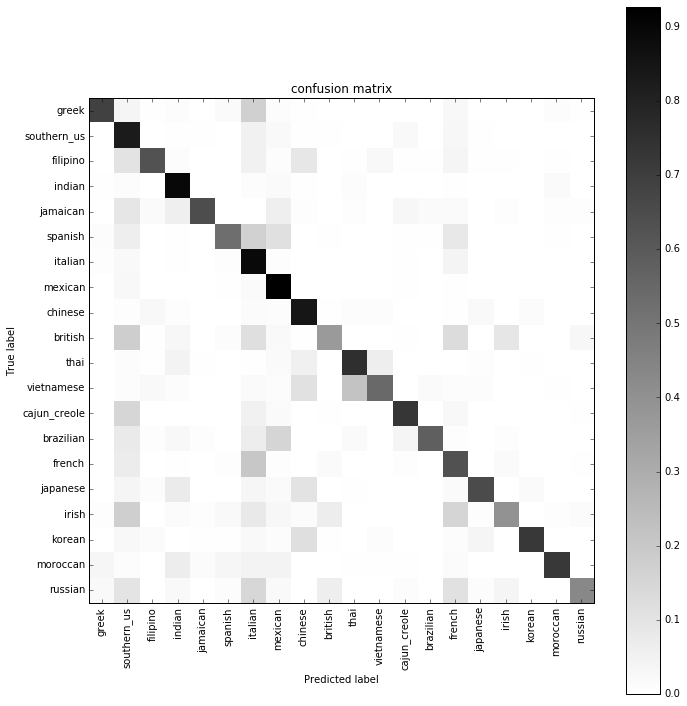

In [18]:
plt.figure(figsize=(10, 10))
cm = confusion_matrix(y_test, logistic.predict(X_test))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.binary)
plt.title("confusion matrix")
plt.colorbar()
tick_marks = np.arange(len(cuisines))
plt.xticks(tick_marks, cuisines, rotation=90)
plt.yticks(tick_marks, cuisines)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('confusion_matrix.png', dpi=200)

In [19]:
%%time
n = test_df.shape[0]
m = len(c.viewkeys())
X_submit = lil_matrix((n, m), dtype=np.int)
for recipe in range(n):
    for ingr in test_df.loc[recipe].ingredients:
        try:
            X_submit[recipe, ingredients_index.index(ingr)] = 1
        except ValueError:
            pass

CPU times: user 19.8 s, sys: 233 ms, total: 20.1 s
Wall time: 19.9 s


In [20]:
y_submit = logistic.predict(X_submit)

In [21]:
def write_to_csv(y_submit, submission_filename='submission.csv'):
    with open(submission_filename, 'w') as f:
        f.write("id,cuisine\n")
        for i, idx in zip(test_df.id, y_submit):
            f.write("{},{}\n".format(i, cuisines[idx]))

In [22]:
write_to_csv(y_submit)

In [23]:
#determine the best value for the c-parameter in the logistic regression
learning_curve = []
for C in [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.8, 0.9, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 10.]:
    clf = LogisticRegression(C=C)
    clf.fit(X_train, y_train)
    learning_curve.append((C, clf.score(X_test, y_test)))
    print(learning_curve[-1])

(0.05, 0.71841609050911381)
(0.1, 0.74142049025769952)
(0.2, 0.75977372721558767)
(0.3, 0.76920175989943429)
(0.4, 0.77410433689503455)
(0.5, 0.77787554996857322)
(0.7, 0.7808925204274042)
(0.8, 0.78227529855436828)
(0.9, 0.78302954116907608)
(1.0, 0.78353236957888117)
(1.5, 0.78403519798868637)
(2.0, 0.78353236957888117)
(2.5, 0.78466373350094276)
(3.0, 0.78466373350094276)
(3.5, 0.78579509742300435)
(4.0, 0.78529226901319926)
(4.5, 0.78428661219358897)
(5.0, 0.78390949088623507)
(10.0, 0.77862979258328091)


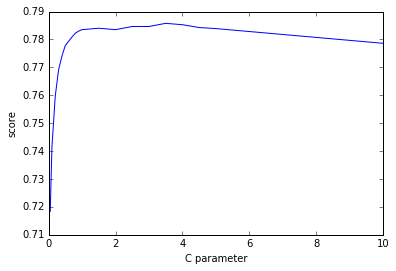

In [24]:
plt.plot(np.array(learning_curve)[:, 0],
        np.array(learning_curve)[:, 1])
plt.xlabel("C parameter")
plt.ylabel("score")

In [25]:
np.array(learning_curve)[:, 0][np.array(learning_curve)[:, 1].argmax()]

3.5

In [26]:
%%time
clf = LogisticRegression(C=1.5)
clf.fit(X, y)
y_submit = clf.predict(X_submit)
write_to_csv(y_submit, "bestC.csv")

CPU times: user 10.2 s, sys: 43.9 ms, total: 10.3 s
Wall time: 10.3 s


In [27]:
#Normalization

In [28]:
c = Counter(";".join([";".join(_) for _ in train_df.ingredients.values]).split(";"))
list(c.keys()).index("butter")
ingredients_index = list(c.keys())

In [29]:
%%time
n = train_df.shape[0]
m = len(c.keys())
X = lil_matrix((n, m), dtype=np.int)
y = np.zeros(n, dtype=np.int)
for recipe in range(n):
    y[recipe] = cuisines.index(train_df.loc[recipe].cuisine)
    for ingr in train_df.loc[recipe].ingredients:
        X[recipe, ingredients_index.index(ingr)] = 1

CPU times: user 1min 21s, sys: 836 ms, total: 1min 22s
Wall time: 1min 21s


In [30]:
%%time
n = test_df.shape[0]
m = len(c.viewkeys())
X_weighted = lil_matrix((n, m), dtype=X.dtype)
for recipe in range(n):
    weight = len(test_df.loc[recipe].ingredients)
    for order, ingr in enumerate(test_df.loc[recipe].ingredients):
        try:
            X_weighted[recipe, ingredients_index.index(ingr)] = 1 + 0.5 * (weight - order) / float(weight)
        except ValueError:
            pass

CPU times: user 20.6 s, sys: 515 ms, total: 21.2 s
Wall time: 20.8 s


In [31]:
np.array((X_weighted[:50, :].todense())).max(axis=1)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1])

(array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,  500.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.]),
 array([ 0.5 ,  0.52,  0.54,  0.56,  0.58,  0.6 ,  0.62,  0.64,  0.66,
         0.68,  0.7 ,  0.72,  0.74,  0.76,  0.78,  0.8 ,  0.82,  0.84,
         0.86,  0.88,  0.9 ,  0.92,  0.94,  0.96,  0.98,  1.  ,  1.02,
         1.04,  1.06,  1.08,  1.1 ,  1.12,  1.14,  1.16,  1.18,  1.2 ,
         1.22,  1.24,  1.26,  1.28,  1.3 ,  1.32,  1.34,  1.36,  1.38,
         1.4 ,  1.42,  1.44,  1.46,  1.48,  1.5 ]),
 <a list of 50 Patch objects>)

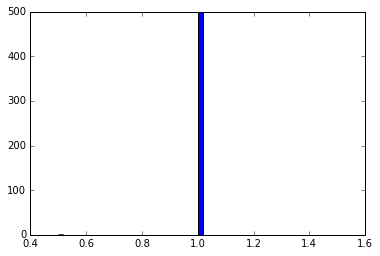

In [32]:
plt.hist(np.array((X_weighted[:500, :].todense())).max(axis=1), bins=50)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [34]:
learning_curve = []
for c in [0.5, 0.75, 1.0, 1.25, 1.5, 2.0]:
    clf = LogisticRegression(C=c)
    clf.fit(X_train, y_train)
    learning_curve.append((c, clf.score(X_test, y_test)))
    print(learning_curve[-1])

(0.5, 0.78114393463230669)
(0.75, 0.78428661219358897)
(1.0, 0.78592080452545565)
(1.25, 0.78642363293526085)
(1.5, 0.78667504714016345)
(2.0, 0.78654934003771215)


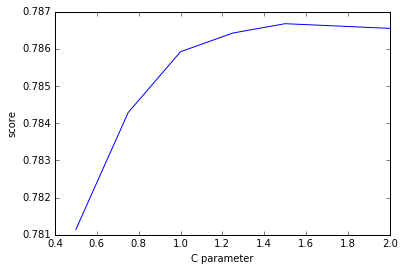

In [35]:
plt.plot(np.array(learning_curve)[:, 0],
         np.array(learning_curve)[:, 1])
plt.xlabel("C parameter")
plt.ylabel("score")

In [36]:
np.array(learning_curve)[:, 0][np.array(learning_curve)[:, 1].argmax()]

1.5

In [37]:
clf = LogisticRegression(C=1.5)
clf.fit(X, y)
y_weighted = clf.predict(X_weighted) # Note: not so good as expected :(

In [38]:
confusion_matrix(y, clf.predict(X))

array([[ 964,   16,    1,   12,    0,   11,  129,    9,    2,    1,    0,
           0,    0,    0,   22,    1,    0,    0,    4,    3],
       [   3, 3855,    5,   15,    5,   12,  116,   73,   10,   16,    3,
           0,  106,    3,   76,    1,    9,    0,    5,    7],
       [   0,   27,  600,    6,    0,    4,   17,   17,   45,    1,   11,
           4,    2,    5,   12,    1,    1,    1,    0,    1],
       [   6,   17,    1, 2856,    2,    0,   27,   33,    3,    1,   13,
           1,    1,    0,   13,    5,    0,    2,   22,    0],
       [   0,   24,    1,   12,  447,    1,   10,   13,    1,    4,    0,
           0,    1,    2,    5,    1,    1,    0,    1,    2],
       [  11,   36,    4,    5,    0,  630,  137,   78,    0,    3,    1,
           0,    7,    1,   64,    2,    2,    0,    6,    2],
       [  42,   88,    1,    9,    0,   22, 7414,   34,    2,    8,    2,
           0,   11,    1,  175,    4,    8,    1,    6,   10],
       [   3,   91,    6,   10,    3,   2

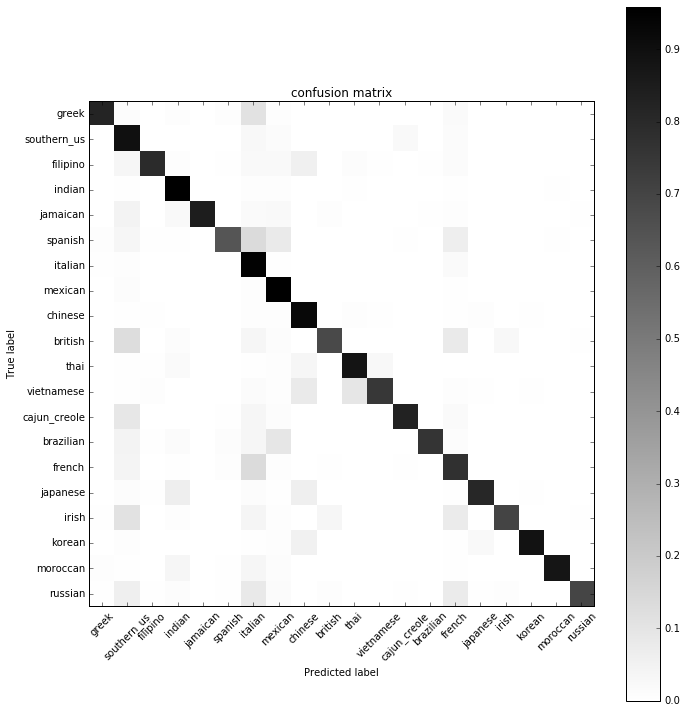

In [39]:
plt.figure(figsize=(10, 10))
cm = confusion_matrix(y, clf.predict(X))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.binary)
plt.title("confusion matrix")
plt.colorbar()
tick_marks = np.arange(len(cuisines))
plt.xticks(tick_marks, cuisines, rotation=45)
plt.yticks(tick_marks, cuisines)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('confusion_matrix.png', dpi=200)

In [40]:
#bag of ingredients
train_df = pd.read_json('train.json')
ingredients_bag = train_df.ingredients[0]
cv = CountVectorizer()
X = cv.fit_transform(ingredients_bag)
X.todense()

matrix([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [41]:
#don't split each element
cv2 = CountVectorizer(token_pattern=r"(?u)\b\w[\w\s]+\b")
X2 = cv2.fit_transform(ingredients_bag)
X2.todense()

matrix([[0, 0, 0, 0, 0, 0, 0, 1, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0]])

In [42]:
cv = CountVectorizer(token_pattern=r"(?u)\b\w[\w\s]+\b")
X = cv.fit_transform([";".join(z) for z in train_df.ingredients])
X.shape

(39774, 6815)

In [43]:
#encode the labels
enc = LabelEncoder()
y = enc.fit_transform(train_df.cuisine)

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [45]:
%%time
logistic = LogisticRegression()
logistic.fit(X_train, y_train)

CPU times: user 8.12 s, sys: 24.7 ms, total: 8.15 s
Wall time: 8.16 s


In [46]:
logistic.score(X_test, y_test)

0.77875549968573221

In [47]:
cv = CountVectorizer(strip_accents='ascii')
X = cv.fit_transform([" ".join(z) for z in train_df.ingredients])
X.shape

(39774, 3005)

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [49]:
%%time
logistic = LogisticRegression()
logistic.fit(X_train, y_train)

CPU times: user 15.4 s, sys: 40.4 ms, total: 15.5 s
Wall time: 15.5 s


In [50]:
logistic.score(X_test, y_test)

0.7922061596480201

In [51]:
cv = CountVectorizer(strip_accents='ascii', ngram_range=(1, 2))
X = cv.fit_transform([" ".join(z) for z in train_df.ingredients])
X.shape

(39774, 81024)

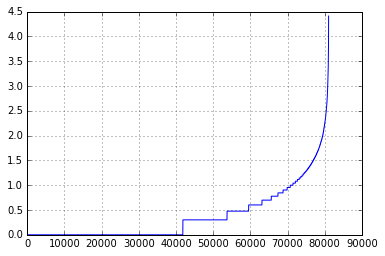

In [52]:
counts = np.array(X.sum(axis=0))[0, :].copy()
counts.sort()
plt.plot(np.log10(counts))
plt.grid(True)

In [53]:
X = X[:, np.log10(counts) < 4] # 4 features
X.shape

(39774, 81010)

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [55]:
%%time
logistic = LogisticRegression()
logistic.fit(X_train, y_train)

CPU times: user 31.8 s, sys: 76.9 ms, total: 31.9 s
Wall time: 31.9 s


In [56]:
logistic.score(X_test, y_test)

0.77875549968573221